<a href="https://colab.research.google.com/github/andreusjh99/Learning-Tensorflow2.0/blob/master/R2_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Core Learning Algorithms 1 - Regression (2)


## **Linear Regression**

In this example, I am using the Kaggle Medical Personal Dataset. This is the second regression example, which includes a problem with multiple features.

Notes on some functions could be found in the first notebook: [R1-Simple Regression](https://github.com/andreusjh99/Learning-Tensorflow2.0/blob/master/R1_Simple_Regression.ipynb).

## Workflow

1. Import stuff
2. Load your dataset using pandas
3. Preprocess the data
4. Create model
5. Train model
6. Evaluate model
7. Visualise results (if possible)

## Setup and imports



In [1]:
!pip install -q sklearn

In [2]:
%tensorflow_version 2.x  # this line is not required unless you are in a notebook

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `2.x  # this line is not required unless you are in a notebook`. This will be interpreted as: `2.x`.


TensorFlow 2.x selected.


In [3]:
!python --version

Python 3.6.9


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from sklearn.model_selection import train_test_split

from IPython.display import clear_output
from six.moves import urllib

import tensorflow.compat.v2.feature_column as fc

In [5]:
print(tf.__version__)

2.2.0


## Upload dataset

The dataset we are using is from the Kaggle Medical Cost Personal dataset: https://www.kaggle.com/mirichoi0218/insurance

The zip file contains only `insurance.csv`

In [6]:
import requests, zipfile, io

r = requests.get( "https://github.com/andreusjh99/Learning-Tensorflow2.0/blob/master/Datasets/MedicalCostKaggle.zip?raw=true" ) 
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall() 

In [7]:
my_data = pd.read_csv("insurance.csv")
my_data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


## Processing the CSV

We parse the values of the features and the labels from the Pandas dataframe. The steps:
1. Convert categorical data to values
2. Normalise the values in numeric columns
3. Form the features array. (`X`)
4. Parse the label values. (`y`)
5. Split the `X` and `y` into training and testing datasets.
6. Convert all the arrays to `tf.Tensor` objects.

In [8]:
# convert categorical values into numerical values
CATEGORICAL_COLUMNS = ['sex', 'smoker', 'region']
NUMERIC_COLUMNS = ['age', 'bmi', 'children']
LABELS = ['charges']

for feature in CATEGORICAL_COLUMNS:
    my_data[feature] = pd.Categorical(my_data[feature]).codes

# normalise
norm_consts = dict() # dict of normalisation constant
for feature in NUMERIC_COLUMNS:
    max = my_data[feature].max()
    min = my_data[feature].min()

    norm_consts[feature] = max - min

    if max != min:
        my_data[feature] = (my_data[feature] - min)/(max - min)

for label in LABELS:
    max = my_data[label].max()
    min = my_data[label].min()

    norm_consts[label] = max - min

    if max != min:
        my_data[label] = (my_data[label] - min)/(max - min)

print(norm_consts)
my_data.head()

{'age': 46, 'bmi': 37.17, 'children': 5, 'charges': 62648.554110000005}


,age,sex,bmi,children,smoker,region,charges
0,0.021739,0,0.321227,0.0,1,3,0.251611
1,0.000000,1,0.479150,0.2,0,2,0.009636
2,0.217391,1,0.458434,0.6,0,2,0.053115
3,0.326087,1,0.181464,0.0,0,1,0.333010
4,0.304348,1,0.347592,0.0,0,1,0.043816


In [9]:
X = my_data[['age', 'sex', 'bmi', 'children', 'smoker', 'region']].values
y = my_data['charges'].values
# this gives numpy arrays of the X and y values. (num_samples, num_features)

# train-test split
train_feats, test_feats, train_labels, test_labels = train_test_split(
    X, y, test_size = 0.2)

# creating tf tensor objects
train_X = tf.constant(train_feats, dtype=tf.float32)
train_y = tf.constant(train_labels, dtype=tf.float32)
test_X = tf.constant(test_feats, dtype=tf.float32)
test_y = tf.constant(test_labels, dtype=tf.float32)

## Creating model

Steps:
1. Define loss fn and its deriv
2. Create the model function
3. Define hyperparameters
4. Define `tf.data.Dataset`

We use mean squared error in this problem.

$\Large MSE( y , \hat{y} ) = \frac{ \sum_{i=0}^{N} ( \hat{y}_i - y_i )^2 } { N }$

In [10]:
# tf.reduce_mean(x) calculate the mean of all values in the tensor x and returns a reduced tensor.

def mean_squared_error(y, y_pred):
    return tf.reduce_mean(tf.square(y_pred - y))

def mean_squared_error_deriv(y, y_pred):
    return tf.reshape(tf.reduce_mean(2*(y_pred - y)), [1, 1])

We create the regression function from scratch here.

$\hat{y} = h(x) = W.X + \mathbf{b}$

In [11]:
def h(X, weights, bias):
    return tf.tensordot(X, weights, axes = 1) + bias

Hyperparameters:
1. epochs
2. batch_size: size of mini-batch used in mini-batch gradient descent
3. learning-rate

In [16]:
num_epochs = 20
num_samples = train_X.shape[0]
batch_size = 10
learning_rate = 0.002

print("No of samples in training dataset: ", num_samples)

No of samples in training dataset:  1070


We also create and shuffle our dataset.

In [17]:
dataset = tf.data.Dataset.from_tensor_slices((train_X, train_y))
dataset = dataset.shuffle(int(num_samples*1.5)) # shuffles data
dataset = dataset.repeat(num_epochs) # repeats the dataset by num_epochs times
dataset = dataset.batch(batch_size) # creates batches of size = batch_size
iterator = dataset.__iter__()

## Training the model

To optimize the parameter $W$, the partial derivative of $MSE$ with respect to $W$ will be,

$\Large \frac{ \partial MSE }{ \partial W} = \frac{ \partial MSE }{ \partial h} * \frac{ \partial h }{ \partial W}$

Similarly for bias $b$ , 

$\Large \frac{ \partial MSE }{ \partial b} = \frac{ \partial MSE }{ \partial h} * 1 $

In [18]:
if len(train_X.shape) > 1:
    num_features = train_X.shape[1]
else:
    num_features = 1

print("No of features: ", num_features)

# note in this example weight is a tensor of shape [1, 1]

No of features:  6


In [19]:
# initialise params
tf.random.set_seed(1001)
weights = tf.random.normal((num_features, 1)) # (num_features, 1)
bias = 0

epochs_plot = list()
loss_plot = list()

# start training
for i in range(num_epochs):

    epoch_loss = list()
    for b in range(int(num_samples/batch_size)):
        x_batch, y_batch = iterator.get_next()

        output = h(x_batch, weights, bias)
        loss = mean_squared_error(y_batch, output).numpy() # .numpy() to get the value of the tensor object
        epoch_loss.append(loss)

        dJ_dH = mean_squared_error_deriv(y_batch, output) # a value
        dH_dW = x_batch # a matrix (batch_size, num_features)
        dJ_dW = tf.reduce_mean(dJ_dH * dH_dW)
        dJ_dB = tf.reduce_mean(dJ_dH)

        weights -= (learning_rate*dJ_dW)
        bias -= (learning_rate*dJ_dB)

    e_loss = np.array(epoch_loss).mean() # mean loss for one epoch
    epochs_plot.append(i + 1)
    loss_plot.append(e_loss)

    if i % 4 == 0:
        print("Epoch {}: Loss is {}".format(i+1, e_loss))

print("Final loss: ", e_loss)

Epoch 1: Loss is 6.757981777191162
Epoch 5: Loss is 0.7060158252716064
Epoch 9: Loss is 0.6953954696655273
Epoch 13: Loss is 0.6860610842704773
Epoch 17: Loss is 0.6686465740203857
Final loss:  0.6675848


## Plot the loss curve

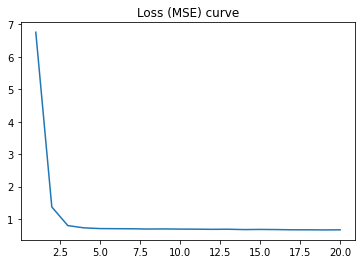

In [20]:
plt.plot( epochs_plot , loss_plot ) 
plt.title("Loss (MSE) curve")
plt.show()

## Evaluate the model

We evaluate our model's performance  by measuring the Mean Squared Error on the test dataset.

In [21]:
output = h( test_X , weights , bias ) 
labels = test_y

accuracy_op = tf.metrics.MeanSquaredError() 
accuracy_op.update_state( labels , output )
print( 'Mean Squared Error = {}'.format( accuracy_op.result().numpy() ) )

Mean Squared Error = 0.6596787571907043


## Visualise result (if possible)


In [22]:
print("weight: ", weights.numpy(), "bias: ", bias.numpy())

weight:  [[ 1.137866  ]
 [-0.3678208 ]
 [ 0.50441927]
 [-0.18112093]
 [-0.15452391]
 [ 0.5969952 ]] bias:  -1.1742789


In [23]:
# plt.scatter(X, y, s = 10)

# # plot line
# line_x = np.linspace(0.0, 10.0, 500)

# line_y = weights.numpy()[0][0]*line_x + bias.numpy()
# plt.plot(line_x, line_y, 'r')
